# Explore Dali Data Pipelines

## Things we need to do
- Verify that we are sharding properly
- Verify the operations that we are running

In [87]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.types as types
import nvidia.dali.fn as fn

In [88]:
image_dir = '../../cv_data/cifar10/train'
batch_size = 4

## Single Pipeline

In [89]:
# example single pipeline
def test_pipeline(device_id):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.file_reader(file_root=image_dir, random_shuffle=False)
        images = fn.image_decoder(jpegs, device='mixed', output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

In [90]:
# Create and build the pipeline
pipe = test_pipeline(device_id = 1)
pipe.build()

# Run pipeline on selected device
images, labels = pipe.run()

In [91]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_dali_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

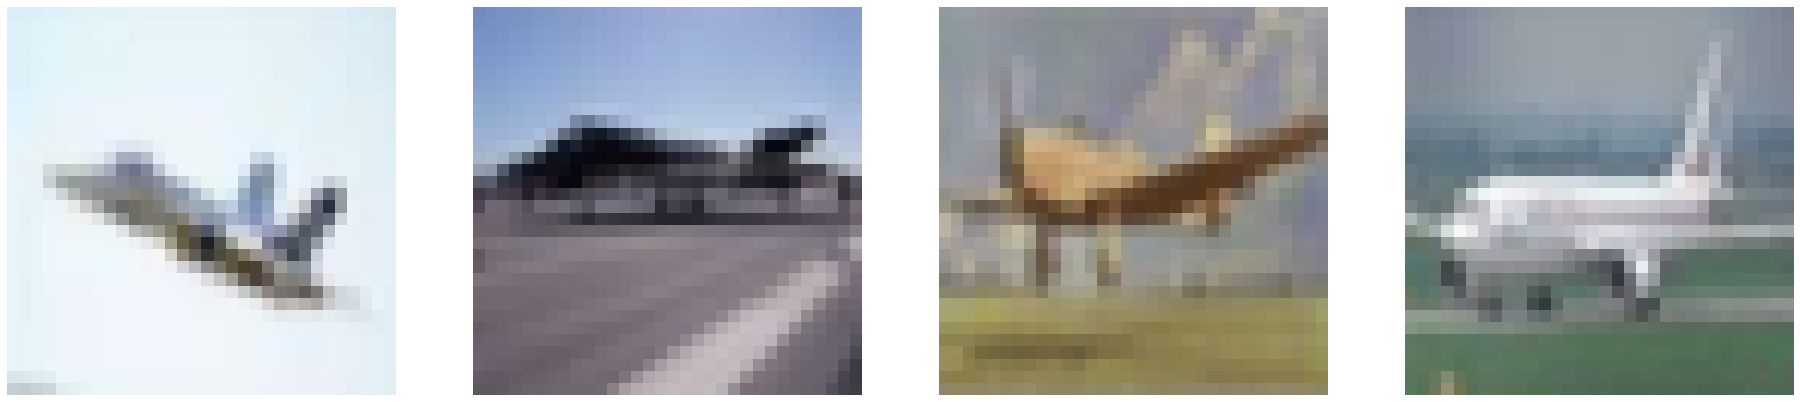

In [92]:
show_dali_images(images.as_cpu())

## Multi-pipeline

In [93]:
def sharded_pipeline(device_id, shard_id, num_shards):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.file_reader(
            file_root=image_dir, random_shuffle=False, shard_id=shard_id, num_shards=num_shards)
        images = fn.image_decoder(jpegs, device='mixed', output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

In [94]:
# Create and build pipelines
pipe_one = sharded_pipeline(device_id=0, shard_id=0, num_shards=2)
pipe_one.build()

pipe_two = sharded_pipeline(device_id=1, shard_id=1, num_shards=2)
pipe_two.build()

# Run pipelines
images_one, labels_one = pipe_one.run()
images_two, labels_two = pipe_two.run()

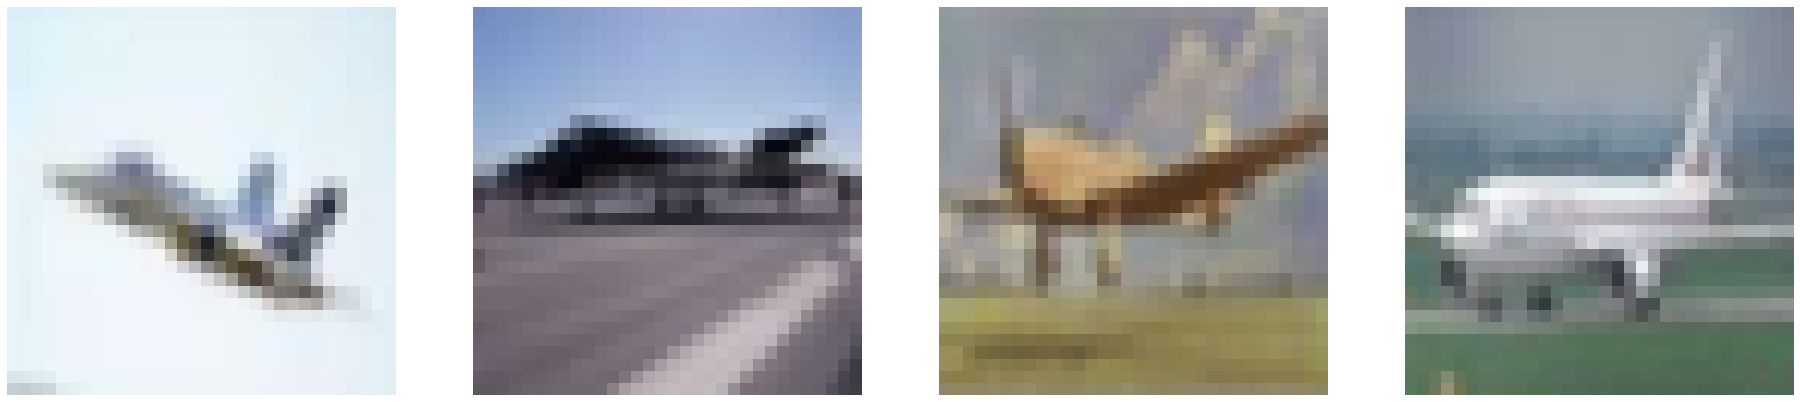

In [95]:
show_dali_images(images_one.as_cpu())

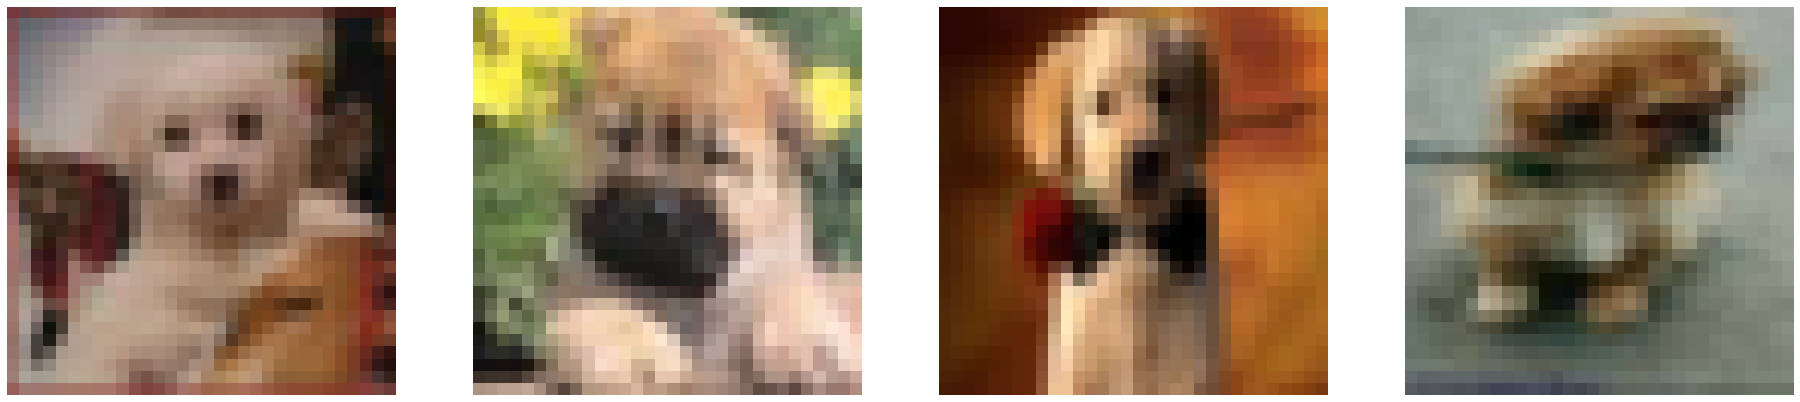

In [96]:
show_dali_images(images_two.as_cpu())

# Testing a DataLoader

In [13]:
from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningDataModule
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [14]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

data_transform = transforms.Compose([
            transforms.Resize((300,300)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

train_data = ImageFolder(
        #root=os.path.join(cifar100, 'train'),
        root=image_dir,
        transform = data_transform
    )

In [15]:
## normal dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, 
                                num_workers=4)

In [16]:
load_test = iter(train_loader)
images, labels = load_test.next()

In [17]:
images.shape

torch.Size([4, 3, 300, 300])

In [86]:
def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(np.transpose(image_batch[j].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


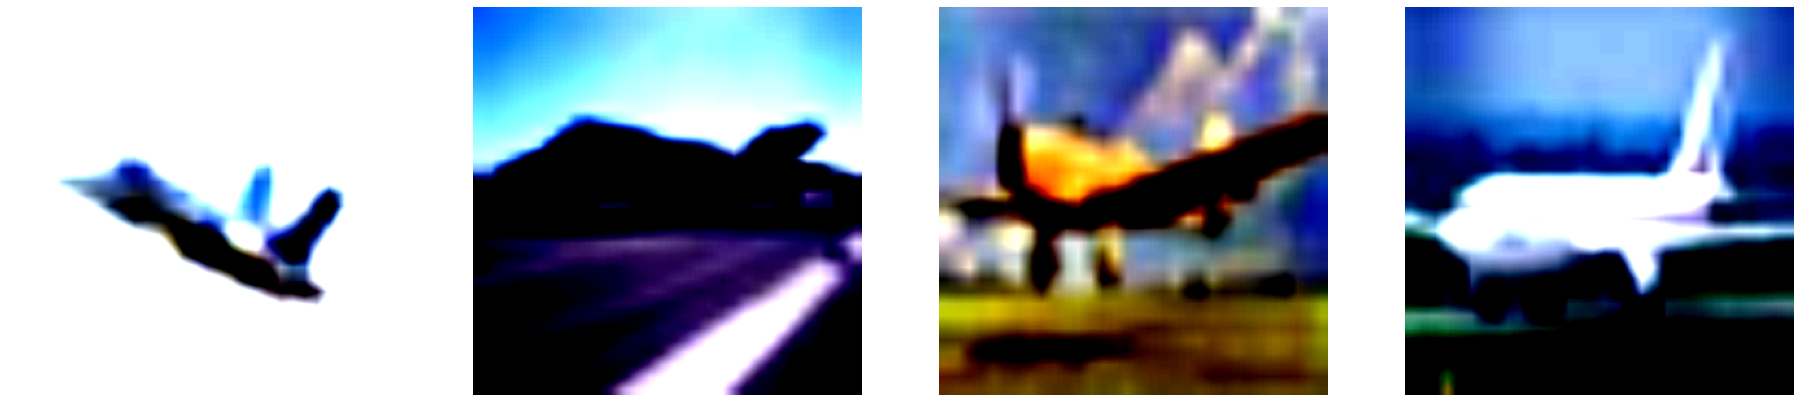

In [19]:
# values are a bit off due to normalise
show_dali_images(images)

## PyTorch Lightning DataLoader

Lets try this thing with a standard data loader to start

In [72]:
class PLDataLoader(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int):
        super().__init__() #self, data_dir, batch_size)
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((300,300)),
            transforms.ToTensor()
        ])
        
    def prepare_data():
        pass
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.training_set = ImageFolder(root=self.data_dir, transform = self.transform)
    
    def train_dataloader(self):
        return DataLoader(self.training_set, batch_size=self.batch_size, num_workers=4)

In [73]:
test = PLDataLoader(image_dir, batch_size)
test.setup()

In [74]:
loader_test = iter(test.train_dataloader())
loader_images, loader_labels = loader_test.next()

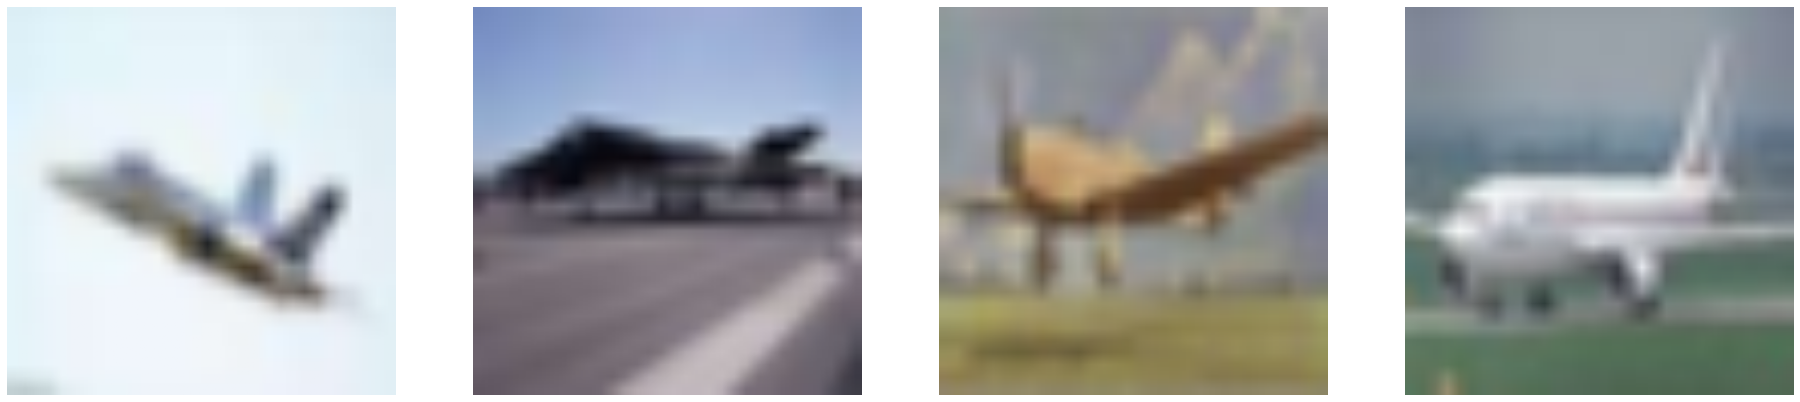

In [75]:
show_images(loader_images)

## Testing Data Loaders

In [119]:
# example single pipeline
def test_pipeline(device_id):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.file_reader(file_root=image_dir, random_shuffle=False)
        images = fn.image_decoder(jpegs, device='mixed', output_type=types.RGB)
        images = fn.crop(images, crop = [28,28], crop_pos_x=0.5, crop_pos_y=0.5)
        images = fn.random_resized_crop(images, size = [14,14])
        pipe.set_outputs(images, labels)

    return pipe

# Create and build the pipeline
pipe = test_pipeline(device_id = 1)
pipe.build()

# Run pipeline on selected device
images, labels = pipe.run()

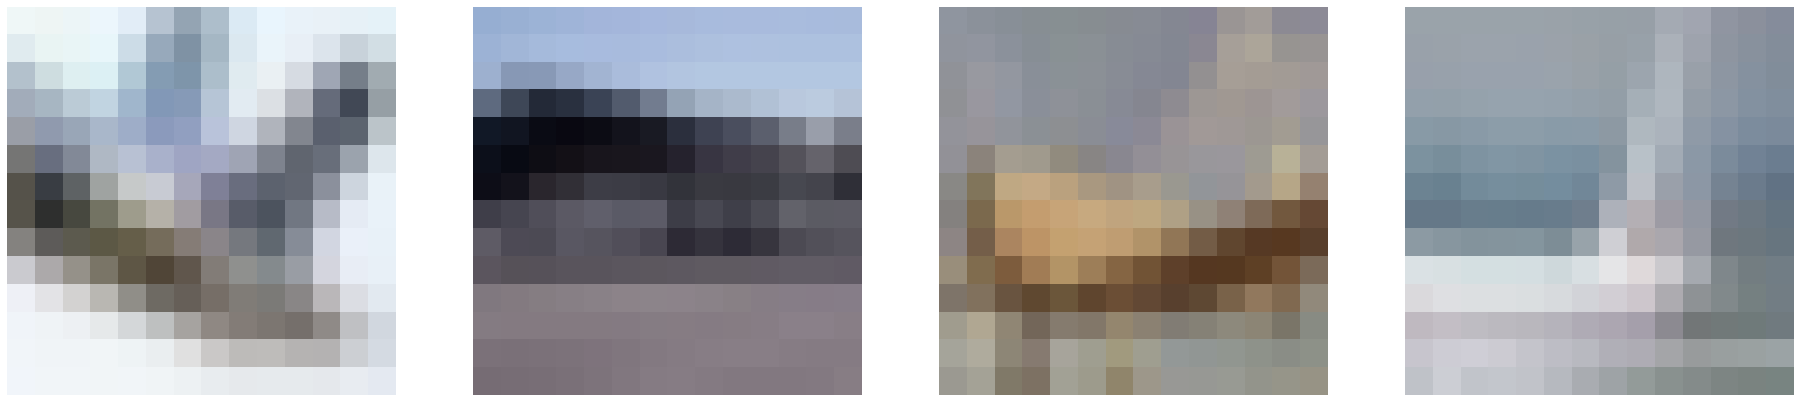

In [120]:
show_dali_images(images.as_cpu())

## Dali Data Loader

In [78]:
# Data Transform class for dali
class DaliTransformsPipeline(Pipeline):
    def __init__(self, batch_size, device, data_dir, device_id=0, shard_id=0, num_shards=1, num_threads=4, seed=0):
        super(DaliTransformsPipeline, self).__init__(
            batch_size, num_threads, device_id, seed)
        self.device = device
        self.reader = ops.FileReader(file_root=data_dir, shard_id=shard_id, num_shards=num_shards, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='mixed', output_type=types.RGB, memory_stats=True)
        
    def define_graph(self):
        jpegs, labels = self.reader()
        images = self.decode(jpegs)
        return images, labels

In [81]:
WORLD_SIZE=2
class PLDaliPipeline(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int):
        super().__init__()
        
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        device_id = self.local_rank # trainer only exists if it is wrapped in a trainer
        shard_id = self.global_rank # trainer only exists if it is wrapped in a trainer
        num_shards = WORLD_SIZE # trainer only exists if it is wrapped in a trainer
        
        if stage == 'fit' or stage is None:
            train_pipeline = DaliTransformsPipeline(batch_size=self.batch_size, device='mixed', data_dir=self.data_dir,
                                                           device_id=device_id, shard_id=shard_id, num_shards=num_shards, num_threads=4, seed=device_id+1)
            
        class LightningWrapper(DALIClassificationIterator):
            def __init__(self, *kargs, **kvargs):
                super().__init__(*kargs, **kvargs)

            def __next__(self):
                out = super().__next__()
                # DDP is used so only one pipeline per process
                # also we need to transform dict returned by DALIClassificationIterator to iterable
                # and squeeze the lables
                out = out[0]
                return [out[k] if k != "label" else torch.squeeze(out[k]) for k in self.output_map]
            
        self.train_loader = LightningWrapper(train_pipeline)
        
    def train_dataloader(self):
        return self.train_loader

In [82]:
DaliTest = PLDaliPipeline(image_dir, batch_size)
DaliTest.setup()

AttributeError: 'PLDaliPipeline' object has no attribute 'local_rank'